<center><h1>DSCI-552 HOMEWORK 2</h1><center>
<br>
<center><font size="4">Linear Regression</font></center>
<center><font size="3"><strong>Mason(Mohan) Xing</font></center>
<center><font size="3"><strong>USCID:	6880083372</font></center>

In [1]:
# import dependencies
import warnings
warnings.filterwarnings("ignore")
import os
import urllib
import zipfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
from sklearn.preprocessing import PolynomialFeatures, normalize
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
# check the environment
print (os.environ['CONDA_DEFAULT_ENV']) 

dsci552


# 1 Combined Cycle Power Plant Data Set

## (a) Download the Combined Cycle Power Plant data from: 
https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant
* You can run these lines to download the dataset

In [2]:
# # download original dataset
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip"
# file = "../data/CCPP.zip"
# urllib.request.urlretrieve(url, file)

# with zipfile.ZipFile(file, 'r') as zip_ref:
#     zip_ref.extractall("../data")
#     zip_ref.close()

# os.remove(file)

## (b)Exploring the data:
### i. How many rows are in this data set? How many columns? What do the rows and columns represent?

In [3]:
data = pd.read_excel('../data/CCPP/Folds5x2_pp.xlsx','Sheet1')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [4]:
print("-"*55)
print(f"Rows: {data.shape[0]}")
print("-"*55)
print(f"Columns: {data.shape[1]}")
print("-"*55)
print(f"The rows present The dataset contains 9568 data points collected from a Combined Cycle \
Power Plant over 6 years (2006-2011)")
print("-"*55)
print(f"The columns present: Features consist of hourly average ambient variables Temperature (T), \
Ambient Pressure (AP), Relative Humidity (RH) and \
Exhaust Vacuum (V) to predict the net hourly electrical energy output (PE) of the plant")
print("-"*55)

-------------------------------------------------------
Rows: 9568
-------------------------------------------------------
Columns: 5
-------------------------------------------------------
The rows present The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011)
-------------------------------------------------------
The columns present: Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (PE) of the plant
-------------------------------------------------------


### ii. Make pairwise scatterplots of all the varianbles in the data set including the predictors (independent variables) with the dependent variable. Describe your findings.

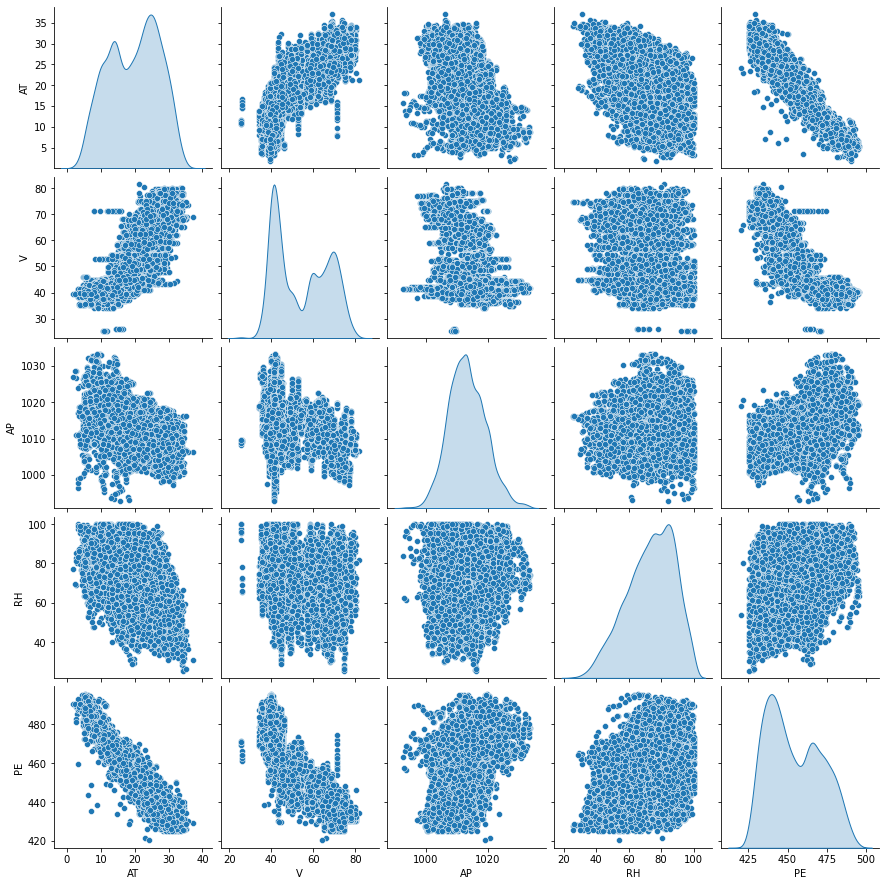

In [5]:
g=sns.pairplot(data, kind='scatter', diag_kind="kde")

From the plot we can see average ambient variables Temperature (AT) and Exhaust Vacuum (V) has a stronge correlation with electrical energy output (PE), moreover ambient variables Temperature (AT) and Exhaust Vacuum (V) has a stronge correlation

### iii. What are the mean, the median, range, first and third quartiles, and interquartile ranges of each of the variables in the dataset? Summarize them in a table.

In [6]:
df_summary = pd.DataFrame({'mean':data.mean(),\
                           'median':data.median(),\
                           'range': (data.max()-data.min()),\
                           'first_quartile': data.quantile(.25),\
                           'third_quartile': data.quantile(.75),\
                           'interquartile': data.quantile(.75)-data.quantile(.25)})
df_summary

,mean,median,range,first_quartile,third_quartile,interquartile
AT,19.651231,20.345,35.30,13.5100,25.72,12.2100
V,54.305804,52.080,56.20,41.7400,66.54,24.8000
AP,1013.259078,1012.940,40.41,1009.1000,1017.26,8.1600
RH,73.308978,74.975,74.60,63.3275,84.83,21.5025
PE,454.365009,451.550,75.50,439.7500,468.43,28.6800


## (c) For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions. Are there any outliers that you would like to remove from your data for each of these regression tasks?

std outlier ref: https://www.statology.org/studentized-residuals-in-python/

In [7]:
# define a linear regression model function
def lm_fit(X_train, y_train):
    
    X_sm = sm.add_constant(X_train)
    # Create the model
    olsmod = sm.OLS(y_train, X_sm)
    # Fit the model to the training data
    olsres = olsmod.fit()
    # Use our model to make predictions
    y_pred = olsres.predict(X_sm)
    
    return(y_pred, olsres)

In [8]:
# define cook distance outliers function
def cookd_outlier(model, column):
    infl = model.get_influence()
    sm_fr = infl.summary_frame()
    threshold = 4/len(data)
    indices = sm_fr.index[sm_fr.cooks_d > threshold]
    df_outliers = pd.DataFrame(data[[column, 'PE']].loc[indices])
    
    return df_outliers

In [9]:
# define Studentized Residuals outliers function
def std_outlier(model, X_train, y_train, column):
    test = model.outlier_test()
    outliers = [(X_train[i],y_train[i]) for i,t in enumerate(test) if abs(t[0]) >3]
    df_outliers = pd.DataFrame(outliers, columns=[column, 'PE'])
    
    return df_outliers

In [10]:
def make_plot(X_train, y_train, y_pred, column, outliers1, outliers2, loc):
    fig, ax = plt.subplots(1,2, figsize=(16,6))
    ax[0].scatter(X_train, y_train , edgecolors= "black", alpha=0.1, label="y_observation")
    ax[0].plot(X_train, y_pred, c='orange', label="y_prediction")
    ax[0].scatter(outliers1.iloc[:, 0], outliers1.iloc[:, 1], c='red',label="Cook distance outliers")
    
    ax[0].legend(loc=loc)
    ax[0].set_title('Electric Energy Output (PE) vs. '+ column)
    ax[0].set_xlabel(column)
    ax[0].set_ylabel("Electric Energy Output (PE)")
    ax[0].grid(True)
    
    ax[1].scatter(X_train, y_train , edgecolors= "black", alpha=0.1, label="y_observation")
    ax[1].plot(X_train, y_pred, c='orange', label="y_prediction")
    ax[1].scatter(outliers2.iloc[:, 0], outliers2.iloc[:, 1], c='green',label="Studentized Residuals outliers")
    
    ax[1].legend(loc=loc)
    ax[1].set_title('Electric Energy Output (PE) vs. '+ column)
    ax[1].set_xlabel(column)
    ax[1].set_ylabel("Electric Energy Output (PE)")
    ax[1].grid(True)

### - PE vs AT

In [11]:
# Assign the data to X and y
y_train = data.PE.values.reshape(-1, 1)
X_train_AT = data.AT.values.reshape(-1, 1)
result = lm_fit(X_train_AT, y_train)
y_pred_AT = result[0]
sm_model_AT = result[1]
print(sm_model_AT.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:12:06   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        497.0341      0.156   3177.280      0.0

* Outliers

In [12]:
df_outliers_AT_cookd = cookd_outlier(sm_model_AT, 'AT')
df_outliers_AT_std = std_outlier(sm_model_AT, X_train_AT, y_train, 'AT')

print('There are', len(df_outliers_AT_cookd), 'outliers by Cook`s Distance')
print('There are', len(df_outliers_AT_std), 'outliers by Studentized Residuals')

There are 416 outliers by Cook`s Distance
There are 42 outliers by Studentized Residuals


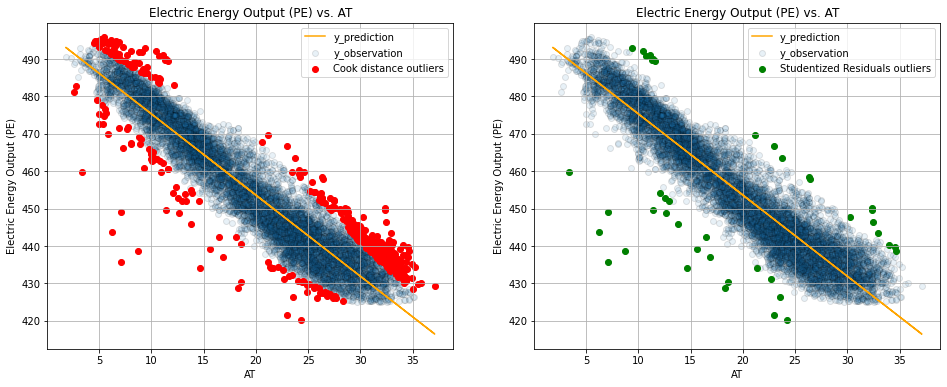

In [13]:
make_plot(X_train_AT, y_train, y_pred_AT, 'AT', df_outliers_AT_cookd, df_outliers_AT_std, "upper right")

* From the plot, we can tell there is a stronge correlation between PE and AT.
* The predictior has a statistically significant association between predictor and the response, since t is approximately 0.

### - PE vs V

In [14]:
X_train_V = data.V.values.reshape(-1, 1)
result = lm_fit(X_train_V, y_train)
y_pred_V = result[0]
sm_model_V = result[1]
print(sm_model_V.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:12:25   Log-Likelihood:                -33963.
No. Observations:                9568   AIC:                         6.793e+04
Df Residuals:                    9566   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        517.8015      0.378   1370.218      0.0

* Outliers

In [15]:
df_outliers_V_cookd = cookd_outlier(sm_model_V, 'V')
df_outliers_V_std = std_outlier(sm_model_V, X_train_V, y_train, 'V')

print('There are', len(df_outliers_V_cookd), 'outliers by Cook`s Distance')
print('There are', len(df_outliers_V_std), 'outliers by Studentized Residuals')

There are 423 outliers by Cook`s Distance
There are 33 outliers by Studentized Residuals


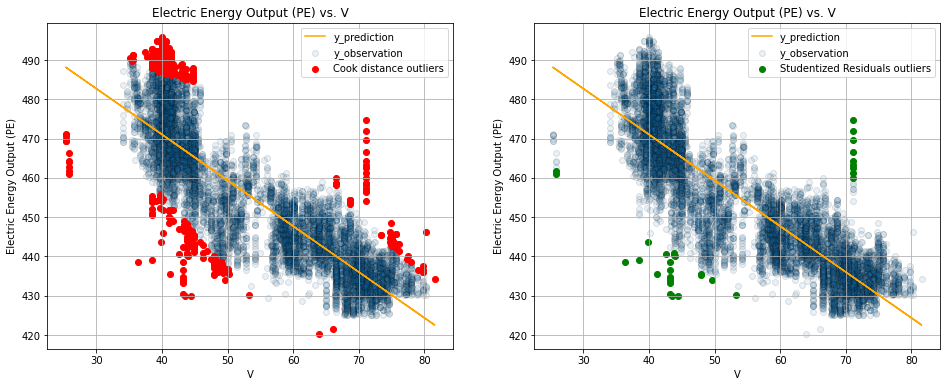

In [16]:
make_plot(X_train_V, y_train, y_pred_V, 'V', df_outliers_V_cookd, df_outliers_V_std, "upper right")

* From the plot, we can tell there is a stronge correlation between PE and V.
* The predictior has a statistically significant association between predictor and the response, since t is approximately 0.

### - PE vs. AP

In [17]:
X_train_AP = data.AP.values.reshape(-1, 1)
result = lm_fit(X_train_AP, y_train)
y_pred_AP = result[0]
sm_model_AP = result[1]
print(sm_model_AP.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:12:45   Log-Likelihood:                -39224.
No. Observations:                9568   AIC:                         7.845e+04
Df Residuals:                    9566   BIC:                         7.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1055.2610     25.459    -41.449      0.0

* Outliers

In [18]:
df_outliers_AP_cookd = cookd_outlier(sm_model_AP, 'AP')
df_outliers_AP_std = std_outlier(sm_model_AP, X_train_AP, y_train, 'AP')

print('There are', len(df_outliers_AP_cookd), 'outliers by Cook`s Distance')
print('There are', len(df_outliers_AP_std), 'outliers by Studentized Residuals')

There are 300 outliers by Cook`s Distance
There are 30 outliers by Studentized Residuals


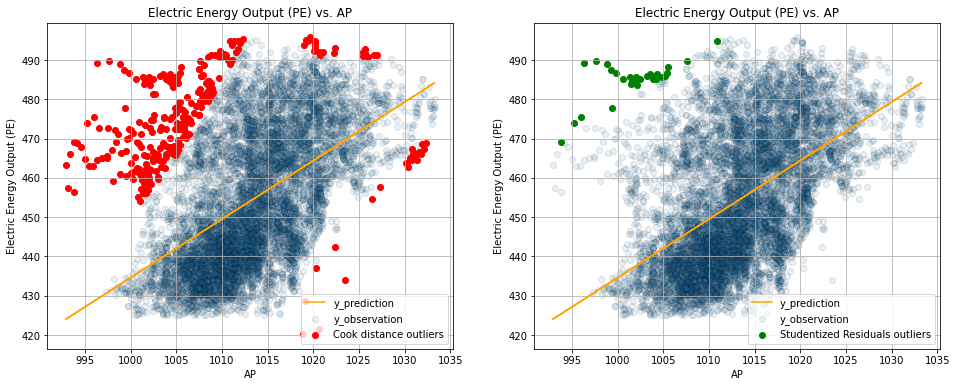

In [19]:
make_plot(X_train_AP, y_train, y_pred_AP, 'AP', df_outliers_AP_cookd, df_outliers_AP_std, "lower right")

* From the plot, we can tell there is a correlation between PE and AP.
* The predictior has a statistically significant association between predictor and the response, since t is approximately 0.

### - PE vs .RH

In [20]:
X_train_RH = data.RH.values.reshape(-1, 1)
result = lm_fit(X_train_RH, y_train)
y_pred_RH = result[0]
sm_model_RH = result[1]
print(sm_model_RH.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:13:05   Log-Likelihood:                -39933.
No. Observations:                9568   AIC:                         7.987e+04
Df Residuals:                    9566   BIC:                         7.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        420.9618      0.823    511.676      0.0

* Outliers

In [21]:
df_outliers_RH_cookd = cookd_outlier(sm_model_RH, 'RH')
df_outliers_RH_std = std_outlier(sm_model_RH, X_train_RH, y_train, 'RH')

print('There are', len(df_outliers_RH_cookd), 'outliers by Cook`s Distance')
print('There are', len(df_outliers_RH_std), 'outliers by Studentized Residuals')

There are 249 outliers by Cook`s Distance
There are 2 outliers by Studentized Residuals


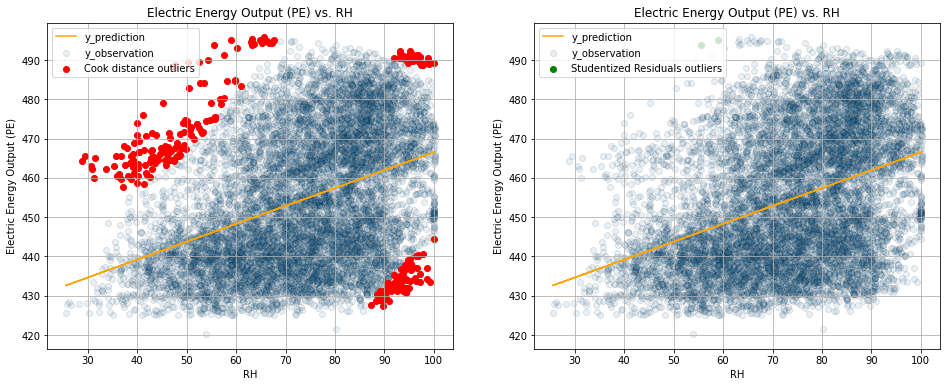

In [22]:
make_plot(X_train_RH, y_train, y_pred_RH, 'RH', df_outliers_RH_cookd, df_outliers_RH_std, "upper left")

* From the plot, we can tell there is a stronge correlation between PE and RH.
* The predictior has a statistically significant association between predictor and the response, since t is approximately 0.

#### Summary
* For each predictor, we can tell there is a statistically relationship between each predictors and response, since the p-value for each predictor is approximate to zero
* In this project, I used two methods to find out the outliers in the the dataset. Moreover, I prefer to use Cook's distance more than the  Studentized Residuals method to find the outliers, I also prefer to remove these outliers from the data to achieve a better prediction.

Outliers: <br/>
Cook's distance: In statistics, Cook's distance or Cook's D is a commonly used estimate of the influence of a data point when performing a least-squares regression analysis. <br/>
studentized residual: In statistics, a studentized residual is the quotient resulting from the division of a residual by an estimate of its standard deviation

## (d) Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis H0 : $\beta\ j = 0? $

In [51]:
y_train = data.PE.values.reshape(-1, 1)
X_train_all = data.iloc[:,0:-1]

print(X_train_all.shape)
print(y_train.shape)

(9568, 4)
(9568, 1)


In [52]:
X_sm = sm.add_constant(X_train_all)
olsmod = sm.OLS(y_train, X_sm)
sm_model_all = olsmod.fit()
print(sm_model_all.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:36:10   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.0

Based on the above table, we can see R-squared is 0.929, this indicates the multi regression model is a good model to describe the relatioship between predictors and respone.</br>
The P values for each predictor is approximate 0.000 in our linear regression summary, therefore we can reject the null hypothesis for all predictors.

## (e) How do your results from 1c compare to your results from 1d? Create a plot displaying the univariate regression coefficients from 1c on the x-axis, and the multiple regression coefficients from 1d on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis.

In [25]:
# Simple regression coefficients
simple_reg_coe = [sm_model_AT.params[1], sm_model_V.params[1], sm_model_AP.params[1], sm_model_RH.params[1]]
# multi- regression coefficients
df_e = (sm_model_all.params).to_frame(name="multi_reg_coe")
df_e_new = df_e.iloc[1: , :]
df_e_new['simple_reg_coe'] = simple_reg_coe
df_e_new

,multi_reg_coe,simple_reg_coe
AT,-1.977513,-2.171320
V,-0.233916,-1.168135
AP,0.062083,1.489872
RH,-0.158054,0.455650


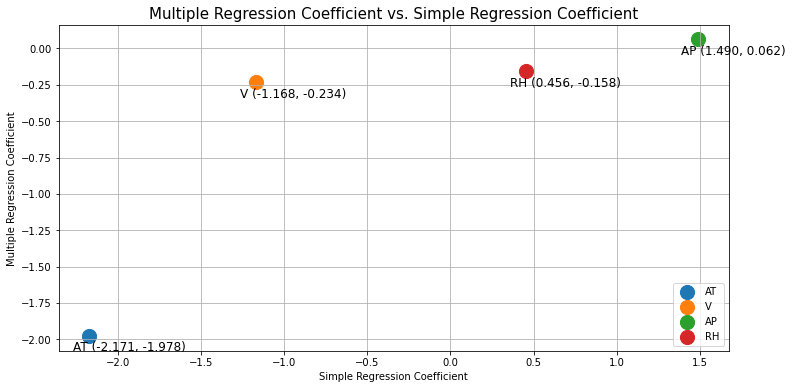

In [26]:
plt.figure(figsize=(12, 6))
for row in df_e_new.iterrows():
    plt.scatter(row[1][1], row[1][0], s=200,label = row[0] )
    plt.text(row[1][1]-0.1,row[1][0]-0.1, "{} ({:0.3f}, {:0.3f})".format(row[0],row[1][1],row[1][0]),fontsize=12)
plt.title("Multiple Regression Coefficient vs. Simple Regression Coefficient",fontsize=15)
plt.xlabel("Simple Regression Coefficient")
plt.ylabel("Multiple Regression Coefficient")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

* We can see the absolute value of multiple regression coefficient is always smaller than the simple regression coefficient
* By comparing the R-squared value, 1d has a closer R-squared value to 1, so that 1d is a better than any 1c linear regression modle to predict the response

## (f) Is there evidence of nonlinear association between any of the predictors and the response? To answer this question, for each predictor X, fit a model of the form Y = $\beta0\ $ +  $\beta1\ $X + $\beta2\ $X^2 + $\beta3\ $ X^3 + $\epsilon\ $

In [27]:
def poly_fit(X_train, y_train):
    
    poly = PolynomialFeatures(3)
    X_poly = poly.fit_transform(X_train)
#     model = LinearRegression()
#     model.fit(X_poly, y_train)
    X_sm = sm.add_constant(X_poly)
    olsmod = sm.OLS(y_train, X_sm)
    olsres = olsmod.fit()
    y_pred = olsres.predict(X_sm)
    
    return(y_pred, olsres)

In [28]:
def make_plot2(X_train, y_train, y_pred, column, loc):
    plt.figure(figsize=(12, 6))
    plt.scatter(X_train, y_train, edgecolors= "black", alpha=0.1, label="y_observation")
    plt.scatter(X_train, y_pred, alpha=1, label="y_prediction")
    plt.grid(True)
    plt.title("Electric Energy Output (PE) vs. " + column ,fontsize=15)
    plt.xlabel(column)
    plt.ylabel("Electric Energy Output (PE)")
    plt.legend(loc=loc)

### - PE vs AT

In [29]:
result = poly_fit(X_train_AT, y_train)
y_pred_AT = result[0]
sm_poly_AT = result[1]
print(sm_poly_AT.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:13:26   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492.7281      0.673    732.248      0.0

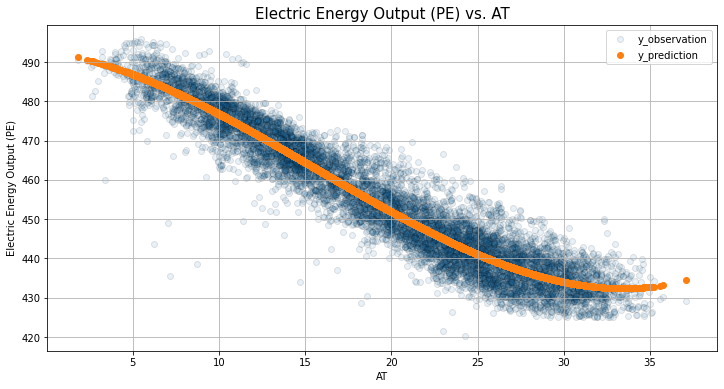

In [30]:
make_plot2(X_train_AT, y_train, y_pred_AT, 'AT', 'upper right')

* PE vs. AT: This nonlinear response shows the coefficient X, X^2 and X^3 have P values are approximately zero. So we can reject the null hypothesis, and tell there is a nonlinear association between PE and AT

### - PE vs V

In [31]:
result = poly_fit(X_train_V, y_train)
y_pred_V = result[0]
sm_poly_V = result[1]
print(sm_poly_V.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:13:26   Log-Likelihood:                -33585.
No. Observations:                9568   AIC:                         6.718e+04
Df Residuals:                    9564   BIC:                         6.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        554.1468      9.151     60.557      0.0

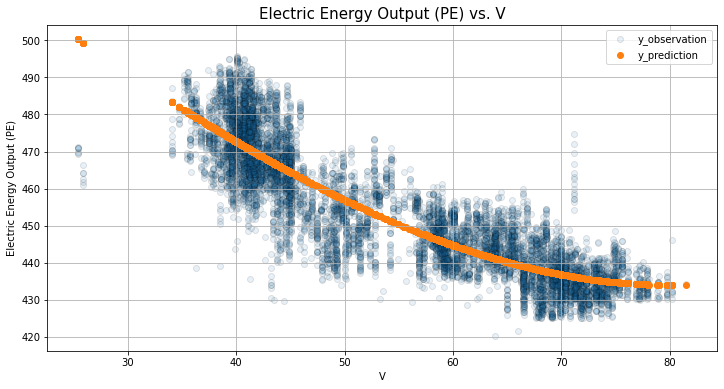

In [32]:
make_plot2(X_train_V, y_train, y_pred_V, 'V', 'upper right')

* PE vs. V: This nonlinear response shows the coefficient X and X^3 have P values are approximately zero. So we can reject the null hypothesis, and tell there is a nonlinear association between EP and V

### - PE vs AP

In [33]:
result = poly_fit(X_train_AP, y_train)
y_pred_AP = result[0]
sm_poly_AP = result[1]
print(sm_poly_AP.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1813.
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:13:26   Log-Likelihood:                -39184.
No. Observations:                9568   AIC:                         7.837e+04
Df Residuals:                    9565   BIC:                         7.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0747      0.009      8.415      0.0

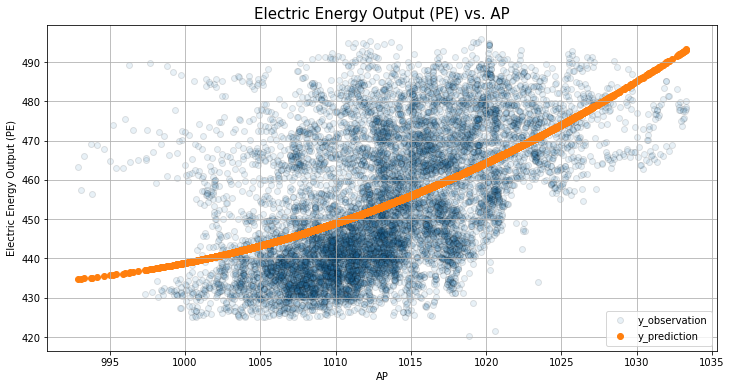

In [34]:
make_plot2(X_train_AP, y_train, y_pred_AP, 'AP', 'lower right')

* PE vs. AP: This nonlinear response shows the coefficient X, X^2 and X^3 have P values are approximately zero. So we can reject the null hypothesis, and tell there is a nonlinear association between EP and AP

### - PE vs RH

In [35]:
result = poly_fit(X_train_RH, y_train)
y_pred_RH = result[0]
sm_poly_RH = result[1]
print(sm_poly_RH.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:13:26   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        468.4135     10.545     44.422      0.0

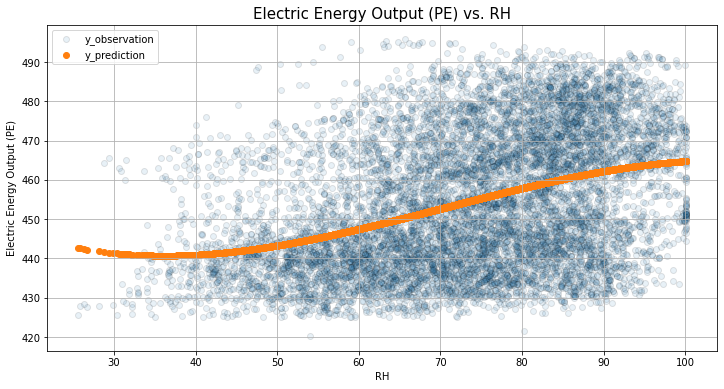

In [36]:
make_plot2(X_train_RH, y_train, y_pred_RH, 'RH', 'upper left')

* PE vs. RH: This nonlinear response shows the coefficient X, X^2 and X^3 have P values are approximately zero. So we can reject the null hypothesis, and tell there is a nonlinear association between EP and AP

## (g) Is there evidence of association of interactions of predictors with the response? To answer this question, run a full linear regression model with all pairwise interaction terms and state whether any interaction terms are statistically significant.

In [37]:
formula = 'PE ~ AT + V + AP + RH + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH'
olsmod = smf.ols(formula = formula, data = data)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:13:26   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    685.7825     78.640      8.721      0.0

* (AT X V), (AT X RH), (V X AP), (AP X RH) have P values are less than 0.05, therefore these interactions are statistically significant

## (h) Can you improve your model using possible interaction terms or nonlinear associations between the predictors and response? Train the regression model on a randomly selected 70% subset of the data with all predictors. Also, run a regression model involving all possible interaction terms and quadratic nonlinearities, and remove insignicant variables using p-values (be careful about interaction terms). Test both models on the remaining points and report your train and test MSEs.

In [38]:
# Train data selected 70% subset of the data with all predictors
y = data.PE
X = data.iloc[:,0:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [39]:
def best_model(X_train, X_test, y_train, y_test, formula):
    data_train = pd.concat([X_train, y_train], axis=1)
    data_test = pd.concat([X_test, y_test], axis=1)
    
    olsmod = smf.ols(formula = formula, data = data_train)
    olsres = olsmod.fit()
    y_train_pred = olsres.predict(data_train)
    y_test_pred = olsres.predict(data_test)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mse_dict = {}
    mse_dict['mse_train'] = mse_train
    mse_dict['mse_test'] = mse_test
    
    return mse_dict, olsres

#### -baseline model involving all features - no nonlinear features or interaction terms are involved

In [40]:
formula = 'PE ~ AT + V + AP + RH'
result = best_model(X_train, X_test, y_train, y_test, formula)
print(result[1].summary())
print("-"*80)
print(result[0])

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 2.194e+04
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:13:26   Log-Likelihood:                -19630.
No. Observations:                6697   AIC:                         3.927e+04
Df Residuals:                    6692   BIC:                         3.930e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    467.8414     11.502     40.673      0.0

#### -The second model involves all the interaction terms & includes quadratic nonlinearities

In [41]:
formula = 'PE ~ AT + V + AP + RH + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH + I(AT**2) + I(V**2) + I(AP**2) + I(RH**2)'
result = best_model(X_train, X_test, y_train, y_test, formula)
print(result[1].summary())
print("-"*80)
print(result[0])

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     7272.
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:13:26   Log-Likelihood:                -19160.
No. Observations:                6697   AIC:                         3.835e+04
Df Residuals:                    6682   BIC:                         3.845e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7664.9809   1429.568     -5.362      0.0

#### - The second model involves all the interaction terms & includes quadratic nonlinearities(modified)

In [42]:
# formula = 'PE ~ AT + V + AP + RH + AT*V + AT*RH + V*AP + AP*RH + I(AT**2) + I(V**2) + I(AP**2) + I(RH**2)'
formula = 'PE ~ AT + V + AP + RH + AT*V + AT*RH + AP*RH + I(AT**2) + I(AP**2) + I(RH**2)'
result_op = best_model(X_train, X_test, y_train, y_test, formula)
print(result_op[1].summary())
print("-"*80)
print(result_op[0])

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                 1.017e+04
Date:                Fri, 24 Sep 2021   Prob (F-statistic):               0.00
Time:                        18:13:26   Log-Likelihood:                -19166.
No. Observations:                6697   AIC:                         3.835e+04
Df Residuals:                    6686   BIC:                         3.843e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.046e+04   1091.512     -9.581      0.0

* I removed the prediction factor based on the P value > 0.05, so all results P values are approximate 0
* The final model has a slightly higher test mse than the one with full interaction term and quadratic nonlinearities which is acceptable. 
* The reason can be many. As professor mentioned in class, there is no perfect model, but the model can be used

## (i) KNN Regression:
## i. Perform k-nearest neighbor regression for this dataset using both normalized and raw features. Find the value of k  {1,2, ... ,100} that gives you the best fit. Plot the train and test errors in terms of 1/k.

In [43]:
def knnclf(knn, k, X_train, X_test, y_train, y_test):
    temp_dict = {}
   
    knn.fit(X_train, y_train)
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)
    # calculate MSE
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)
    #construct output dict
    temp_dict['k'] = k
    temp_dict['mse_train'] = train_error
    temp_dict['mse_test'] = test_error
    return temp_dict

In [44]:
k_set = list(range(1, 101))
knn = KNeighborsRegressor()

#### - Normalized features

In [45]:
y = data.PE
X = data.iloc[:,0:-1]
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)

y_train = y.values.reshape(-1,1)
y_test = y.values.reshape(-1,1)


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

result_list = []
for k in k_set:
    knn.set_params(n_jobs=-1,n_neighbors=k)
    result = knnclf(knn, k, X_train, X_test, y_train, y_test)
    result_list.append(result)
df_i_norm = pd.DataFrame(result_list)

In [46]:
# minimum test mse
min_test_mse_norm = min(df_i_norm.mse_test)
min_test_k_norm = (df_i_norm.loc[df_i_norm.mse_test == min_test_mse_norm]['k']).tolist()

# minimum train mse
min_train_mse_norm = min(df_i_norm.mse_train)
min_train_k_norm = (df_i_norm.loc[df_i_norm.mse_train == min_train_mse_norm]['k']).tolist()

print("Minimum test K: ", min_test_k_norm)
print("Minimum test MSE: " , min_test_mse_norm)
print("Minimum train K: ", min_train_k_norm)
print("Minimum train MSE: " , min_train_mse_norm)

Minimum test K:  [4]
Minimum test MSE:  14.348653474399166
Minimum train K:  [1]
Minimum train MSE:  0.0


#### - Raw features

In [47]:
y = data.PE
X = data.iloc[:,0:-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

result_list = []
for k in k_set:
    knn.set_params(n_jobs=-1,n_neighbors=k)
    result = knnclf(knn, k, X_train, X_test, y_train, y_test)
    result_list.append(result)
df_i_raw = pd.DataFrame(result_list)

In [48]:
# minimum test mse
min_test_mse_raw = min(df_i_raw.mse_test)
min_test_k_raw = (df_i_raw.loc[df_i_raw.mse_test == min_test_mse_raw]['k']).tolist()

# minimum train mse
min_train_mse_raw = min(df_i_raw.mse_train)
min_train_k_raw = (df_i_raw.loc[df_i_raw.mse_train == min_train_mse_raw]['k']).tolist()

print("Minimum test K: ", min_test_k_raw)
print("Minimum test MSE: " , min_test_mse_raw)
print("Minimum train K: ", min_train_k_raw)
print("Minimum train MSE: " , min_train_mse_raw)

Minimum test K:  [5]
Minimum test MSE:  15.726819842563568
Minimum train K:  [1]
Minimum train MSE:  0.0


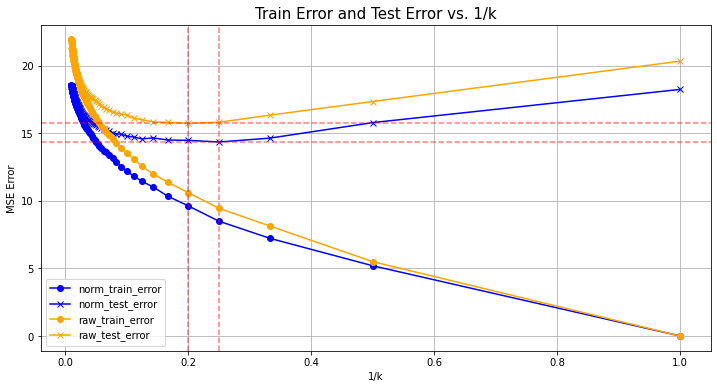

In [49]:
# Making plot
plt.figure(figsize=(12, 6))     
plt.plot(1/np.array(k_set), df_i_norm.mse_train, c='blue', marker='o', label="norm_train_error")
plt.plot(1/np.array(k_set), df_i_norm.mse_test, c='blue', marker="x", label="norm_test_error")
plt.axhline(min_test_mse_norm, color='r', alpha=0.5, linestyle='--')
plt.axvline(1/min_test_k_norm[0], color='r', alpha=0.5, linestyle='--')

plt.plot(1/np.array(k_set), df_i_raw.mse_train, c='orange', marker='o', label="raw_train_error")
plt.plot(1/np.array(k_set), df_i_raw.mse_test, c='orange',marker="x", label="raw_test_error")
plt.axhline(min_test_mse_raw, color='r', alpha=0.5, linestyle='--')
plt.axvline(1/min_test_k_raw[0], color='r', alpha=0.5, linestyle='--')
plt.grid(True)
plt.title("Train Error and Test Error vs. 1/k",fontsize=15)
plt.xlabel("1/k")
plt.ylabel("MSE Error")
plt.legend(loc="lower left")
plt.show()

## (j) Compare the results of KNN Regression with the linear regression model that has the smallest test error and provide your analysis.

In [50]:
df_j = pd.DataFrame({"test error":[result_op[0]["mse_test"], min_test_mse_norm,  min_test_mse_raw]},\
                    index=["LinearRegression", "normKNN", "rawKNN"])
df_j

,test error
LinearRegression,18.694346
normKNN,14.348653
rawKNN,15.726820


* Comparing KNN method and linear regression method: KNN model has a relative lower MSE than Linear Regression Model. This indicates KNN model is better than linear regression method in this case.
* Comparing normalized KNN and Raw KNN method: the normalized features gives out a lower MSE than raw features. 
* The reason is standardizing the features around the center and 0 with a standard deviation of 1 is important when we compare measurements that have different units. Variables that are measured at different scales do not contribute equally to the analysis and might end up creating a bias.

# ISLR:2.4.1

### 1. For each of parts (a) through (d), indicate whether we would generally expect the performance of a flexible statistical learning method to be better or worse than an inflexible method. Justify your answer.

#### (a) The sample size n is extremely large, and the number of predictors p is small.

Answer: Better. The large number of samples and low numbers of features using a flexible stastical method can reduce the bias and have a less chance overfitting.

#### (b) The number of predictors p is extremely large, and the number of observations n is small.

Answer: Worse. The small number of samples and high features can cause more bias, since the model will fit the noise as well

#### (c) The relationship between the predictors and response is highly non-linear.

Answer: Better. Non-linear means it will have less bias and it fits better when there is high degree of freedom

#### (d) The variance of the error terms, i.e. σ2 = Var(ϵ), is extremely high.

Answer: Worse. Variance is extremely high means the model will fit the noise and cause overfitting problem

# ISLR:2.4.7

### (a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.

obs1: sqrt( (0-0)^2 + (3-0)^2 + (0-0)^2 ) = 3 <br /> 
obs2: sqrt( (2-0)^2 + (0-0)^2 + (0-0)^2 ) = 2 <br /> 
obs3: sqrt( (0-0)^2 + (1-0)^2 + (3-0)^2 ) = 3.162 <br />
obs4: sqrt( (0-0)^2 + (1-0)^2 + (2-0)^2 ) = 2.236 <br />
obs5: sqrt( (-1-0)^2 + (0-0)^2 + (1-0)^2 ) = 1.414 <br />
obs6: sqrt( (1-0)^2 + (1-0)^2 + (1-0)^2 ) = 1.732 <br />

### (b) What is our prediction with K = 1? Why?

Green. Since when K equals 1, which means the closest neighbor when we sort obss. The smallest obs distance is 1.414 which is obs5(Y Green).

### (c) What is our prediction with K = 3? Why?

Red. Since when K equals 3, which means the closest 3 neighbors are obs5(green), obs6(red), obs2(red), based on polling by majority rule it is red

### (d) If the Bayes decision boundary in this problem is highly nonlinear, then would we expect the best value for K to be large or small? Why?

Small. Since we choose our final prediction by polling on majority, if K is very large then there will be neighbors far away from the given points then the decision will moved towards number of the dominate classes rather than neighbors by distance. Therefore, K needs to be small so the dominate class could be more accurate. 